## Feature Selection


In [3]:
# === 0. Imports & Settings ===
# Step 0. Imports & 기본 설정
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

# 경로/설정 (환경에 맞게 수정)
MON_PATH = "mon_standard.pkl"
UNMON_PATH = "unmon_standard10.pkl"

USE_SUBLABEL = False      # True면 각 URL을 다른 클래스, False면 사이트 단위 라벨
URL_PER_SITE = 10         # 사이트당 URL 수
TOTAL_MON_URLS = 950      # 전체 monitored URL 수 (ex: 95 sites * 10 urls)
TOTAL_UNMON = 10000       # 불러올 unmonitored 샘플 수 (필요시)

In [4]:
# Step 1-1. Data loading functions
def load_monitored(
    mon_path=MON_PATH,
    use_sublabel=USE_SUBLABEL,
    url_per_site=URL_PER_SITE,
    total_urls=TOTAL_MON_URLS
):
    """
    mon_standard.pkl 로부터
    X1(timestamp seq), X2(direction*size seq), y(label) 리턴
    """
    print("[Monitored] Loading:", mon_path)
    with open(mon_path, "rb") as f:
        data = pickle.load(f)

    X1, X2, y = [], [], []

    for i in range(total_urls):
        # 사이트 라벨 (0~94)
        label = i if use_sublabel else i // url_per_site

        for sample in data[i]:
            t_seq, s_seq = [], []
            for c in sample:
                dr = 1 if c > 0 else -1
                t_seq.append(abs(c))       # timestamp
                s_seq.append(dr * 512)     # 방향 * 고정 size
            X1.append(t_seq)
            X2.append(s_seq)
            y.append(label)

    y = np.array(y)
    print(f"[Monitored] Samples: {len(y)}, #Classes: {len(np.unique(y))}")
    return X1, X2, y

# Step 1-2. 32개 feature 추출
def extract_features_final(X1_list, X2_list):
    features = []
    feature_names = [
        'TotalTime', 'TotalPackets', 'TotalVolume',
        'NumIncoming', 'NumOutgoing', 'IncomingRatio', 'OutgoingRatio', 'InOutDiff',
        'Global_Slope', 'First30_InRatio',
        'IPI_Mean', 'IPI_Std', 'IPI_Max', 'IPI_Min', 'IPI_Skew', 'IPI_Kurt',
        'IPI_P10', 'IPI_P25', 'IPI_P50', 'IPI_P75', 'IPI_P90',
        'Size_P10', 'Size_P25', 'Size_P50', 'Size_P75', 'Size_P90',
        'BurstLen_Count', 'BurstLen_Mean', 'BurstLen_Std', 'BurstLen_Max', 'BurstLen_Min',
        'BurstVol_Mean', 'BurstVol_Std', 'BurstVol_Max', 'BurstVol_Min',
        'CumSum_Mean', 'CumSum_Std'
    ]

    for X1, X2 in zip(X1_list, X2_list):
        X1 = np.array(X1)
        X2 = np.array(X2)
        total_packets = len(X2)
        abs_sizes = np.abs(X2)

        # Basic Stats
        num_in = np.sum(X2 < 0)
        num_out = np.sum(X2 > 0)
        total_vol = np.sum(abs_sizes)
        in_ratio = num_in / total_packets if total_packets > 0 else 0.0
        out_ratio = num_out / total_packets if total_packets > 0 else 0.0
        diff = num_in - num_out

        # First 30
        f30 = X2[:30]
        f30_in = np.sum(f30 < 0)
        f30_ratio = f30_in / len(f30) if len(f30) > 0 else 0.0

        if total_packets > 1:
            total_time = X1[-1] - X1[0]
            ipi = np.diff(X1)
            # IPI Stats
            ipi_mean = float(np.mean(ipi))
            ipi_std = float(np.std(ipi))
            ipi_max = float(np.max(ipi))
            ipi_min = float(np.min(ipi))
            ipi_skew = float(stats.skew(ipi))
            ipi_kurt = float(stats.kurtosis(ipi))
            ipi_p = np.percentile(ipi, [10, 25, 50, 75, 90])
            # Size Stats
            size_p = np.percentile(abs_sizes, [10, 25, 50, 75, 90])
            # Cumulative
            cumsum = np.cumsum(abs_sizes)
            cum_mean = float(np.mean(cumsum))
            cum_std = float(np.std(cumsum))
            slope = total_vol / total_time if total_time > 0 else 0.0

            # Burst
            bl, bv = [], []
            if total_packets > 0:
                cur_dir = X2[0] > 0
                cur_len = 0
                cur_vol = 0
                for x in X2:
                    d = (x > 0)
                    size = abs(x)
                    if d == cur_dir:
                        cur_len += 1
                        cur_vol += size
                    else:
                        bl.append(cur_len)
                        bv.append(cur_vol)
                        cur_dir = d
                        cur_len = 1
                        cur_vol = size
                bl.append(cur_len)
                bv.append(cur_vol)

            if len(bl) > 0:
                b_count = len(bl)
                bl_mean = float(np.mean(bl))
                bl_std = float(np.std(bl))
                bl_max = float(np.max(bl))
                bl_min = float(np.min(bl))
                bv_mean = float(np.mean(bv))
                bv_std = float(np.std(bv))
                bv_max = float(np.max(bv))
                bv_min = float(np.min(bv))
            else:
                b_count = 0
                bl_mean = bl_std = bl_max = bl_min = 0.0
                bv_mean = bv_std = bv_max = bv_min = 0.0
        else:
            total_time = 0.0
            slope = 0.0
            ipi_mean = ipi_std = ipi_max = ipi_min = 0.0
            ipi_skew = ipi_kurt = 0.0
            ipi_p = [0.0] * 5
            size_p = [0.0] * 5
            cum_mean = cum_std = 0.0
            b_count = 0
            bl_mean = bl_std = bl_max = bl_min = 0.0
            bv_mean = bv_std = bv_max = bv_min = 0.0

        feature_vector = [
            total_time, total_packets, total_vol,
            num_in, num_out, in_ratio, out_ratio, diff,
            slope, f30_ratio,
            ipi_mean, ipi_std, ipi_max, ipi_min, ipi_skew, ipi_kurt, *ipi_p,
            *size_p,
            b_count, bl_mean, bl_std, bl_max, bl_min,
            bv_mean, bv_std, bv_max, bv_min,
            cum_mean, cum_std
        ]
        features.append(feature_vector)

    return np.array(features), feature_names


# DataFrame로 변환 (build_feature_df 대체)
def build_feature_df(X1, X2):
    X_feats, feat_names = extract_features_final(X1, X2)
    return pd.DataFrame(X_feats, columns=feat_names)

# Step 1-3. 실행
X1_mon, X2_mon, y_mon = load_monitored()
X_df = build_feature_df(X1_mon, X2_mon)
print("Feature shape:", X_df.shape)
print("Columns:", X_df.columns.tolist())

# 메모리 절약
del X1_mon, X2_mon
gc.collect()


[Monitored] Loading: mon_standard.pkl
[Monitored] Samples: 19000, #Classes: 95
Feature shape: (19000, 37)
Columns: ['TotalTime', 'TotalPackets', 'TotalVolume', 'NumIncoming', 'NumOutgoing', 'IncomingRatio', 'OutgoingRatio', 'InOutDiff', 'Global_Slope', 'First30_InRatio', 'IPI_Mean', 'IPI_Std', 'IPI_Max', 'IPI_Min', 'IPI_Skew', 'IPI_Kurt', 'IPI_P10', 'IPI_P25', 'IPI_P50', 'IPI_P75', 'IPI_P90', 'Size_P10', 'Size_P25', 'Size_P50', 'Size_P75', 'Size_P90', 'BurstLen_Count', 'BurstLen_Mean', 'BurstLen_Std', 'BurstLen_Max', 'BurstLen_Min', 'BurstVol_Mean', 'BurstVol_Std', 'BurstVol_Max', 'BurstVol_Min', 'CumSum_Mean', 'CumSum_Std']


0

상관관계 분석 및 Feature 중요도 탐색

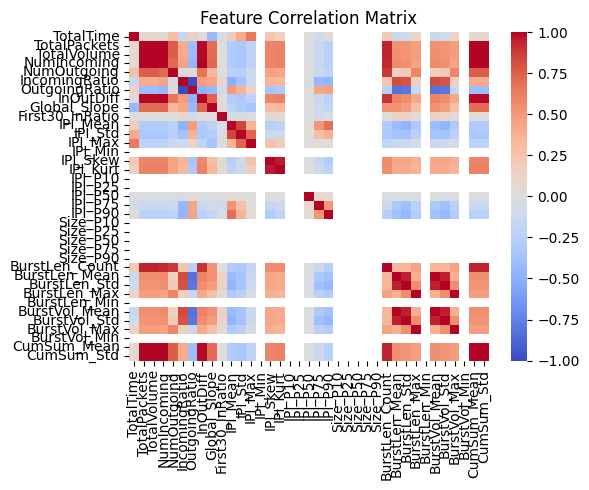

=== High correlation pairs (|r| >= 0.9) ===
TotalPackets         - TotalVolume         : r = 1.000
TotalPackets         - NumIncoming         : r = 0.998
TotalPackets         - InOutDiff           : r = 0.991
TotalPackets         - BurstLen_Count      : r = 0.944
TotalPackets         - CumSum_Mean         : r = 1.000
TotalPackets         - CumSum_Std          : r = 1.000
TotalVolume          - NumIncoming         : r = 0.998
TotalVolume          - InOutDiff           : r = 0.991
TotalVolume          - BurstLen_Count      : r = 0.944
TotalVolume          - CumSum_Mean         : r = 1.000
TotalVolume          - CumSum_Std          : r = 1.000
NumIncoming          - InOutDiff           : r = 0.997
NumIncoming          - BurstLen_Count      : r = 0.925
NumIncoming          - CumSum_Mean         : r = 0.998
NumIncoming          - CumSum_Std          : r = 0.998
IncomingRatio        - OutgoingRatio       : r = -1.000
InOutDiff            - CumSum_Mean         : r = 0.991
InOutDiff           

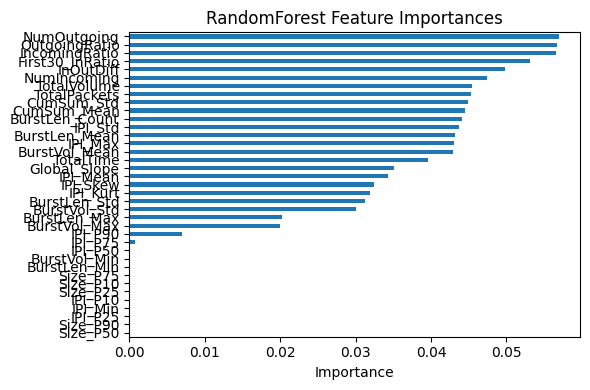

In [5]:
# Step 2-1. 상관관계 분석
corr = X_df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=False, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 강한 상관관계 쌍 출력
high_corr_pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr.iloc[i, j]
        if abs(val) >= 0.9:
            high_corr_pairs.append((cols[i], cols[j], val))

print("=== High correlation pairs (|r| >= 0.9) ===")
for a, b, v in high_corr_pairs:
    print(f"{a:20s} - {b:20s}: r = {v:.3f}")

# Step 2-2. 기본 RF로 feature importance
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_df.values, y_mon,
    test_size=0.2,
    stratify=y_mon,
    random_state=42
)

rf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train_all, y_train_all)

y_pred_base = rf_base.predict(X_test_all)
base_acc_all = accuracy_score(y_test_all, y_pred_base)
print(f"\n[Base RF] Accuracy with all 10 features: {base_acc_all:.4f}")

importances = pd.Series(rf_base.feature_importances_, index=X_df.columns).sort_values(ascending=False)
print("\n=== RF Feature Importances ===")
print(importances)

plt.figure(figsize=(6, 4))
importances.sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()


In [6]:
# ----------------------------------------------------
# Step 2-3. 상관 높은 피처 자동 제거 + 정확도 비교해보기
#   - high_corr_pairs: |r| >= 0.9 인 쌍 (위에서 이미 계산됨)
#   - importances: RF feature importance (위에서 이미 계산됨)
# ----------------------------------------------------

# 1) 학습/테스트 인덱스 한 번만 고정해서 사용
n_samples = len(y_mon)
indices = np.arange(n_samples)
idx_train_corr, idx_test_corr = train_test_split(
    indices,
    test_size=0.2,
    stratify=y_mon,
    random_state=42   # baseline과 같은 seed 써도 되고, 다르게 써도 됨
)

def rf_acc_with_indices(feature_df, labels, idx_train, idx_test):
    """주어진 feature_df 컬럼들로 RF 한 번 학습해서 accuracy 리턴"""
    X_train = feature_df.iloc[idx_train].values
    X_test  = feature_df.iloc[idx_test].values
    y_train = labels[idx_train]
    y_test  = labels[idx_test]

    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# 2) baseline: 아무것도 안 지운 상태
base_acc_corr = rf_acc_with_indices(X_df, y_mon, idx_train_corr, idx_test_corr)
print(f"\n[CorrPrune] Baseline (all {X_df.shape[1]} features): {base_acc_corr:.4f}")

# 3) 상관 높은 pair들에서 중요도 낮은 쪽을 drop 후보로 선택
to_drop_corr = set()
for a, b, r in high_corr_pairs:
    # importances 는 Series라 이름으로 바로 비교 가능
    if importances[a] < importances[b]:
        to_drop_corr.add(a)
    else:
        to_drop_corr.add(b)

print("\n[CorrPrune] Drop candidates from high-corr pairs:")
for f in sorted(to_drop_corr):
    print("  -", f)

# 4) 실제로 해당 피처들을 제거한 뒤 정확도 측정
kept_cols = [c for c in X_df.columns if c not in to_drop_corr]
X_pruned = X_df[kept_cols]

pruned_acc = rf_acc_with_indices(X_pruned, y_mon, idx_train_corr, idx_test_corr)
delta = pruned_acc - base_acc_corr

print(f"\n[CorrPrune] After dropping {len(to_drop_corr)} features "
      f"(keep {len(kept_cols)}): acc = {pruned_acc:.4f} (Δ = {delta:+.4f})")


[CorrPrune] Baseline (all 37 features): 0.7655

[CorrPrune] Drop candidates from high-corr pairs:
  - BurstLen_Count
  - BurstLen_Std
  - BurstVol_Max
  - BurstVol_Mean
  - BurstVol_Std
  - CumSum_Mean
  - CumSum_Std
  - IPI_Kurt
  - IncomingRatio
  - NumIncoming
  - TotalPackets
  - TotalVolume

[CorrPrune] After dropping 12 features (keep 25): acc = 0.7282 (Δ = -0.0374)


* 상관관계가 높은 Feature들을 pruning 했더니 오히려 정확도 소폭 감소 (Δ = -0.0374)

In [7]:
# ----------------------------------------------------
# Step 2-4. Importance=0 feature 제거 + 정확도 비교
# ----------------------------------------------------

# 0에 아주 가까운(사실상 0) feature들만 선택
zero_importance_feats = importances[importances <= 1e-6].index.tolist()
print("\n=== Near-zero importance features ===")
print(zero_importance_feats)
print(f"#Zero importance: {len(zero_importance_feats)}")

# baseline accuracy using original set
base_acc_imp = rf_acc_with_indices(X_df, y_mon, idx_train_corr, idx_test_corr)
print(f"\n[ImpPrune] Baseline (all {X_df.shape[1]} features): {base_acc_imp:.4f}")

# drop zero-importance features
X_imp_pruned = X_df.drop(columns=zero_importance_feats)
acc_imp_pruned = rf_acc_with_indices(X_imp_pruned, y_mon, idx_train_corr, idx_test_corr)
delta_imp = acc_imp_pruned - base_acc_imp

print(f"[ImpPrune] After dropping {len(zero_importance_feats)} features "
      f"(keep {X_imp_pruned.shape[1]}): acc = {acc_imp_pruned:.4f} (Δ = {delta_imp:+.4f})")



=== Near-zero importance features ===
['IPI_Min', 'IPI_P10', 'IPI_P25', 'Size_P90', 'Size_P50', 'Size_P75', 'Size_P10', 'Size_P25', 'BurstLen_Min', 'BurstVol_Min']
#Zero importance: 10

[ImpPrune] Baseline (all 37 features): 0.7655
[ImpPrune] After dropping 10 features (keep 27): acc = 0.7679 (Δ = +0.0024)


* 강한상관관계를 제거했을 때와 다르게, Importance가 0인 Feature들을 제거하자 정확도 소폭 상승 (Δ = +0.0024)

In [8]:
# ============================================
# Step 3. Outlier(IQR) + Accuracy 비교
#   - full 37 features vs pruned 27 features
# ============================================

# 1) IQR 기반 이상치 제거 함수
def clean_outliers_iqr(df):
    """
    df의 각 컬럼별로 IQR(1.5*IQR) 기준으로 이상치를 제거하고
    - 정제된 DataFrame
    - 사용된 boolean mask
    를 반환
    """
    mask = np.ones(len(df), dtype=bool)

    for col in df.columns:
        data = df[col].values
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        col_mask = (data >= lower) & (data <= upper)
        mask &= col_mask

    df_clean = df[mask].reset_index(drop=True)
    return df_clean, mask

# 2) RF 학습 + accuracy 계산 함수
def train_eval_rf_df(df, y, label=""):
    X = df.values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{label} accuracy: {acc:.4f}")
    return acc


# === 3-1. Feature set 정의 ===
X_full = X_df.copy()                                   # 37개 전체
X_pruned = X_df.drop(columns=zero_importance_feats).copy()  # 27개

print(f"Full features: {X_full.shape[1]}")
print(f"Pruned features: {X_pruned.shape[1]}")

# === 3-2. IQR 이상치 제거 ===
X_full_clean, mask_full = clean_outliers_iqr(X_full)
y_full_clean = y_mon[mask_full]

X_pruned_clean, mask_pruned = clean_outliers_iqr(X_pruned)
y_pruned_clean = y_mon[mask_pruned]

print(f"\n[Outlier removal]")
print(f"Full:   {len(X_full)} -> {len(X_full_clean)}")
print(f"Pruned: {len(X_pruned)} -> {len(X_pruned_clean)}")

# === 3-3. Accuracy 측정 (4가지 조합) ===
acc_full_raw    = train_eval_rf_df(X_full,         y_mon,          "[Full 37 / Raw]")
acc_full_clean  = train_eval_rf_df(X_full_clean,   y_full_clean,   "[Full 37 / Clean]")
acc_pruned_raw  = train_eval_rf_df(X_pruned,       y_mon,          "[Pruned 27 / Raw]")
acc_pruned_clean= train_eval_rf_df(X_pruned_clean, y_pruned_clean, "[Pruned 27 / Clean]")

# 정리
acc_summary = pd.DataFrame({
    "config": ["full_raw", "full_clean", "pruned_raw", "pruned_clean"],
    "n_features": [X_full.shape[1], X_full_clean.shape[1],
                   X_pruned.shape[1], X_pruned_clean.shape[1]],
    "n_samples": [len(X_full), len(X_full_clean),
                  len(X_pruned), len(X_pruned_clean)],
    "accuracy": [acc_full_raw, acc_full_clean, acc_pruned_raw, acc_pruned_clean]
})

print("\n=== Accuracy summary ===")
print(acc_summary)

# === 3-4. 가장 좋은 설정 선택 ===
best_row = acc_summary.iloc[acc_summary["accuracy"].idxmax()]
best_config = best_row["config"]
print(f"\n[Best config] {best_config} (acc={best_row['accuracy']:.4f})")

# best 설정에 맞게 raw/clean 데이터 선택
if best_config.startswith("full"):
    best_raw_df   = X_full
    best_clean_df = X_full_clean
else:
    best_raw_df   = X_pruned
    best_clean_df = X_pruned_clean

best_features = best_raw_df.columns.tolist()
print(f"Best feature set size: {len(best_features)}")

Full features: 37
Pruned features: 27

[Outlier removal]
Full:   19000 -> 11905
Pruned: 19000 -> 11905
[Full 37 / Raw] accuracy: 0.7655
[Full 37 / Clean] accuracy: 0.8085
[Pruned 27 / Raw] accuracy: 0.7679
[Pruned 27 / Clean] accuracy: 0.8118

=== Accuracy summary ===
         config  n_features  n_samples  accuracy
0      full_raw          37      19000  0.765526
1    full_clean          37      11905  0.808484
2    pruned_raw          27      19000  0.767895
3  pruned_clean          27      11905  0.811844

[Best config] pruned_clean (acc=0.8118)
Best feature set size: 27


* 이상치를 제거한 환경에서 실험 결과, 37개 Feature를 사용하는 기본 모델과 27개 Feature를 사용하는 모델 둘 다 정확도가 3%이상 상승

* 37개를 사용한 모델보다 27개를 사용했을 때의 정확도가 조금 더 높으므로 27개 Feature 모델을 select

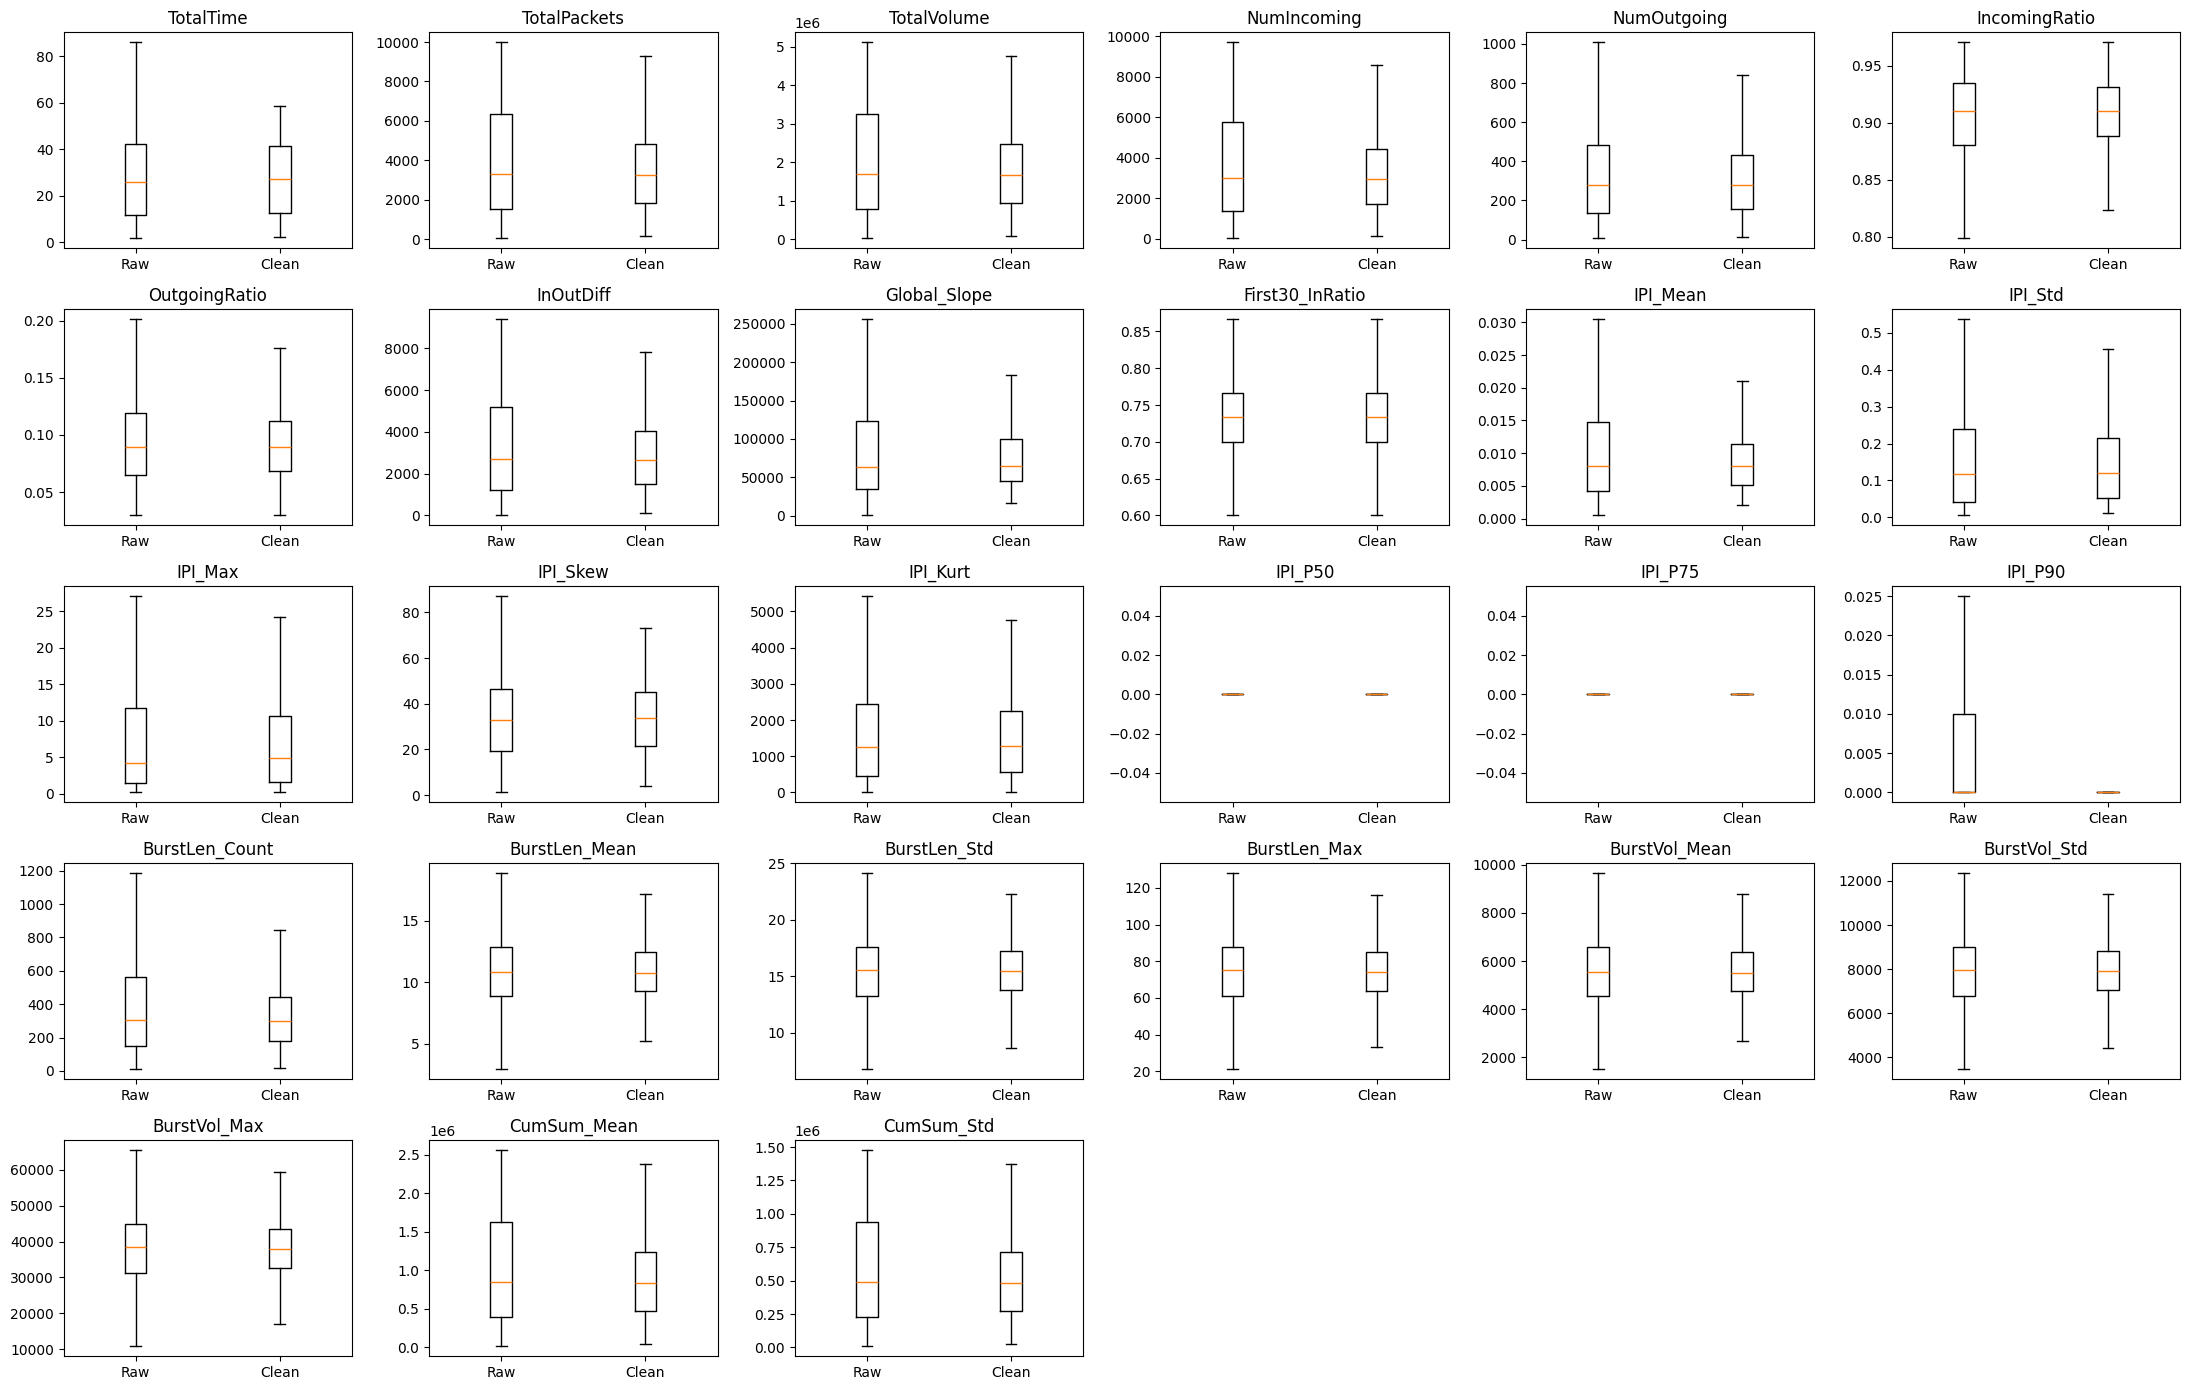

In [9]:
# ============================================
# Step 4. Raw vs Clean Log Boxplot (best config)
# ============================================

plt.figure(figsize=(22, 14))
for i, col in enumerate(best_clean_df.columns, 1):
    plt.subplot(5, 6, i)
    plt.boxplot([best_raw_df[col], best_clean_df[col]],
                tick_labels=["Raw", "Clean"],
                showfliers=False)
    plt.title(col)
plt.tight_layout()
plt.show()

* Box Plot을 그려 이상치 제거 전/후 비교

In [10]:
print(np.unique(best_raw_df["IPI_P50"])[:10], "...", len(np.unique(best_raw_df["IPI_P50"])))
print(np.unique(best_clean_df["IPI_P50"])[:10], "...", len(np.unique(best_clean_df["IPI_P50"])))

[0.   0.01] ... 2
[0.] ... 1


* 선처럼 보이는 그래프들의 경우, 실수치의 변화 정도가 미미하여 다른 plot들과 다른 형태를 띔


[Ablation-clean] Baseline (all 27 feats): 0.8118
 - drop TotalTime       -> acc=0.8131 (Δ=+0.0013)
 - drop TotalPackets    -> acc=0.8144 (Δ=+0.0025)
 - drop TotalVolume     -> acc=0.8144 (Δ=+0.0025)
 - drop NumIncoming     -> acc=0.8102 (Δ=-0.0017)
 - drop NumOutgoing     -> acc=0.8102 (Δ=-0.0017)
 - drop IncomingRatio   -> acc=0.8060 (Δ=-0.0059)
 - drop OutgoingRatio   -> acc=0.8039 (Δ=-0.0080)
 - drop InOutDiff       -> acc=0.8139 (Δ=+0.0021)
 - drop Global_Slope    -> acc=0.8097 (Δ=-0.0021)
 - drop First30_InRatio -> acc=0.7673 (Δ=-0.0445)
 - drop IPI_Mean        -> acc=0.8190 (Δ=+0.0071)
 - drop IPI_Std         -> acc=0.8060 (Δ=-0.0059)
 - drop IPI_Max         -> acc=0.8097 (Δ=-0.0021)
 - drop IPI_Skew        -> acc=0.8131 (Δ=+0.0013)
 - drop IPI_Kurt        -> acc=0.8144 (Δ=+0.0025)
 - drop IPI_P50         -> acc=0.8081 (Δ=-0.0038)
 - drop IPI_P75         -> acc=0.8081 (Δ=-0.0038)
 - drop IPI_P90         -> acc=0.8131 (Δ=+0.0013)
 - drop BurstLen_Count  -> acc=0.8131 (Δ=+0.0013)


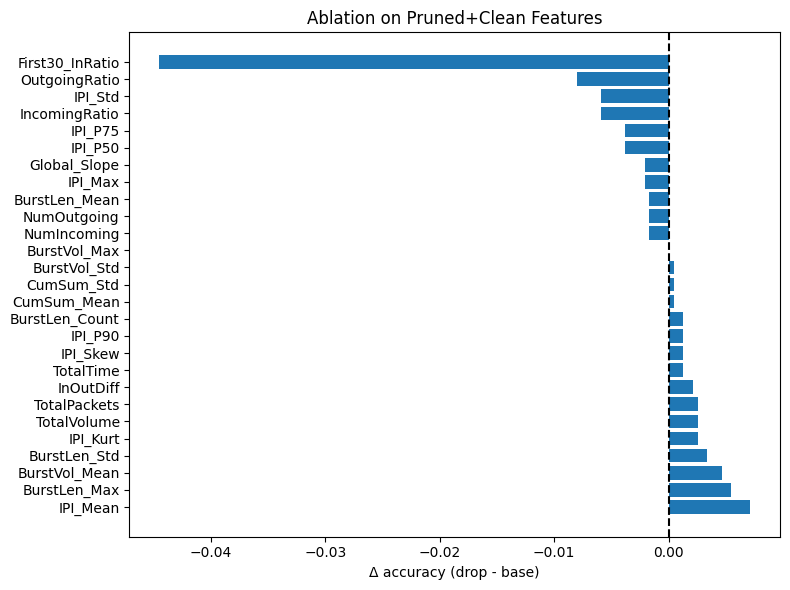

In [11]:
# ============================================
# Ablation Test on pruned+clean (27 features)
# ============================================

features = X_pruned_clean.columns.tolist()

# train/test split 고정
idx_all = np.arange(len(y_pruned_clean))
idx_train_ab, idx_test_ab = train_test_split(
    idx_all,
    test_size=0.2,
    stratify=y_pruned_clean,
    random_state=42
)

def run_rf_ablation(df, y, idx_train, idx_test):
    X_train = df.iloc[idx_train].values
    X_test  = df.iloc[idx_test].values
    y_train = y[idx_train]
    y_test  = y[idx_test]

    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# baseline: 27개 다 쓴 경우
base_acc_clean = run_rf_ablation(X_pruned_clean, y_pruned_clean,
                                 idx_train_ab, idx_test_ab)
print(f"\n[Ablation-clean] Baseline (all {len(features)} feats): {base_acc_clean:.4f}")

# 하나씩 제거하면서 accuracy 측정
ablation_res = []
for f in features:
    df_drop = X_pruned_clean.drop(columns=[f])
    acc = run_rf_ablation(df_drop, y_pruned_clean, idx_train_ab, idx_test_ab)
    delta = acc - base_acc_clean
    ablation_res.append({"feature": f, "acc": acc, "delta": delta})
    print(f" - drop {f:15s} -> acc={acc:.4f} (Δ={delta:+.4f})")

ablation_df = (
    pd.DataFrame(ablation_res)
    .sort_values("acc", ascending=False)
    .reset_index(drop=True)
)

print("\n=== Ablation (clean, pruned) summary ===")
print(ablation_df)

# delta 기준으로 시각화
plt.figure(figsize=(8, 6))
plt.barh(ablation_df["feature"], ablation_df["delta"])
plt.axvline(0.0, linestyle="--", color="black")
plt.xlabel("Δ accuracy (drop - base)")
plt.title("Ablation on Pruned+Clean Features")
plt.tight_layout()
plt.show()


Ablation test 후 Noise 가능성이 있는, 제거했을 때 accuarcy가 올라가는 Feature들을 대상으로 조합을 바꿔가며 Ablation test 진행

In [12]:
from itertools import combinations

to_drop = ["IPI_Mean", "BurstLen_Max", "BurstVol_Mean", "BurstLen_Std"]

results = []

for r in range(1, len(to_drop)+1):
    for combo in combinations(to_drop, r):
        drop_list = list(combo)
        df_tmp = X_pruned_clean.drop(columns=drop_list)

        acc = run_rf_ablation(df_tmp, y_pruned_clean, idx_train_ab, idx_test_ab)
        results.append({
            "drop_list": drop_list,
            "num_feats": df_tmp.shape[1],
            "accuracy": acc
        })
        print(f"Drop {drop_list} -> acc = {acc:.4f}")

# sort by accuracy
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

print("\n=== Best Feature Combination Results ===")
for r in results:
    print(r)


Drop ['IPI_Mean'] -> acc = 0.8190
Drop ['BurstLen_Max'] -> acc = 0.8173
Drop ['BurstVol_Mean'] -> acc = 0.8165
Drop ['BurstLen_Std'] -> acc = 0.8152
Drop ['IPI_Mean', 'BurstLen_Max'] -> acc = 0.8152
Drop ['IPI_Mean', 'BurstVol_Mean'] -> acc = 0.8156
Drop ['IPI_Mean', 'BurstLen_Std'] -> acc = 0.8165
Drop ['BurstLen_Max', 'BurstVol_Mean'] -> acc = 0.8093
Drop ['BurstLen_Max', 'BurstLen_Std'] -> acc = 0.8127
Drop ['BurstVol_Mean', 'BurstLen_Std'] -> acc = 0.8118
Drop ['IPI_Mean', 'BurstLen_Max', 'BurstVol_Mean'] -> acc = 0.8156
Drop ['IPI_Mean', 'BurstLen_Max', 'BurstLen_Std'] -> acc = 0.8152
Drop ['IPI_Mean', 'BurstVol_Mean', 'BurstLen_Std'] -> acc = 0.8152
Drop ['BurstLen_Max', 'BurstVol_Mean', 'BurstLen_Std'] -> acc = 0.8144
Drop ['IPI_Mean', 'BurstLen_Max', 'BurstVol_Mean', 'BurstLen_Std'] -> acc = 0.8165

=== Best Feature Combination Results ===
{'drop_list': ['IPI_Mean'], 'num_feats': 26, 'accuracy': 0.8189836203275934}
{'drop_list': ['BurstLen_Max'], 'num_feats': 26, 'accuracy': 0.

* IPI_Mean을 제거했을 때 best score(0.8190) 달성하여, 해당 Feature를 제거한 26개 조합을 후보에 추가

검증을 위해 평가함수를 이용하여 37개, 27개, 26개 사용했을 때 비교

In [13]:
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc,
    classification_report
)

# ---------------------------------------------------------
# 만능 평가 함수 (테이블 + 그래프)
# ---------------------------------------------------------
def evaluate_model_performance(model, X_test, y_test, model_name, scenario="binary"):
    """
    모델 성능을 테이블과 그래프로 시각화하는 함수
    - Scenario: 'binary' (Open-World 탐지), 'multi' (Closed/Open 식별)
    """
    print(f"\n{'='*80}")
    print(f"📢 [Evaluation Result] {model_name}")
    print(f"{'='*80}")

    # 1. 예측
    start_pred = time.time()
    y_pred = model.predict(X_test)

    # 확률 (ROC/PR용)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = None

    # 2. Metrics 계산
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_test, y_pred)

    if scenario == "binary":
        # Monitored(1) vs Unmonitored(-1) -> Positive Label = 1
        metrics['Precision'] = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        metrics['Recall'] = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        metrics['F1-Score'] = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

        # Unmonitored(-1) 관점의 Recall (중요!)
        unmon_recall = recall_score(y_test, y_pred, pos_label=-1, zero_division=0)
        metrics['Unmon_Recall'] = unmon_recall

        if y_prob is not None:
            try: metrics['ROC-AUC'] = roc_auc_score(y_test, y_prob[:, 1])
            except: metrics['ROC-AUC'] = 0.0

    else: # Multi-Class
        metrics['Precision'] = precision_score(y_test, y_pred, average='macro', zero_division=0)
        metrics['Recall'] = recall_score(y_test, y_pred, average='macro', zero_division=0)
        metrics['F1-Score (Macro)'] = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # Open-World Multi의 경우 Unmonitored Recall 추가 표시
        if -1 in y_test:
             unmon_mask = (y_test == -1)
             metrics['Unmon_Recall'] = np.mean(y_pred[unmon_mask] == -1)

    # 3. 결과 테이블 출력
    df_metrics = pd.DataFrame([metrics], index=[model_name])
    print("\n✅ Performance Metrics:")
    display(df_metrics)

    # 4. 그래프 시각화
    plt.figure(figsize=(12, 5))

    # (1) Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)

    # 클래스가 너무 많으면 숫자 생략, 적으면 표시
    annot = True if cm.shape[0] < 20 else False
    sns.heatmap(cm, annot=annot, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix ({scenario})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # (2) ROC / PR Curve (Binary Only)
    if scenario == "binary" and y_prob is not None:
        plt.subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
        roc_auc = metrics.get('ROC-AUC', 0)

        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC={roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

        # PR Curve 추가 (점선)
        prec, rec, _ = precision_recall_curve(y_test, y_prob[:, 1], pos_label=1)
        pr_auc = auc(rec, prec)
        plt.plot(rec, prec, color='green', linestyle=':', lw=2, label=f'PR (AUC={pr_auc:.3f})')

        plt.title("ROC & Precision-Recall Curves")
        plt.xlabel("False Positive Rate / Recall")
        plt.ylabel("True Positive Rate / Precision")
        plt.legend(loc="best")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    if scenario == "binary":
        print("\n📋 Detailed Report:")
        print(classification_report(y_test, y_pred, target_names=['Unmonitored (-1)', 'Monitored (1)']))

[Common IQR] 37 feats: 19000 -> 11905 samples (공통 데이터)
37 feats columns: 37
27 feats columns: 27
26 feats columns: 26

📢 [Evaluation Result] RF - 37 feats (baseline)

✅ Performance Metrics:


,Accuracy,Precision,Recall,F1-Score (Macro)
RF - 37 feats (baseline),0.808484,0.793342,0.772464,0.774184


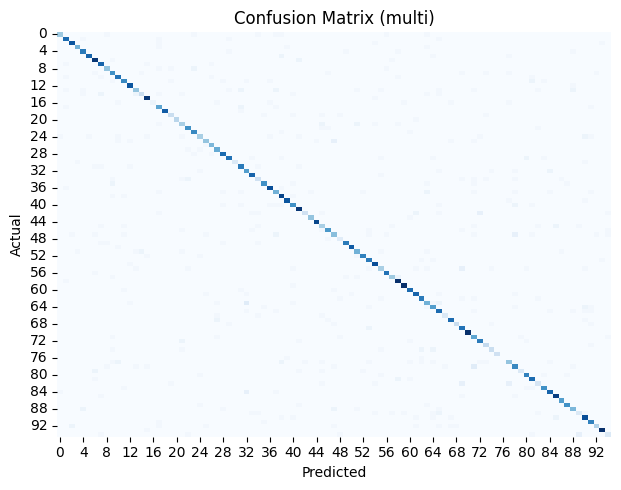


📢 [Evaluation Result] RF - 27 feats (zero-imp pruned)

✅ Performance Metrics:


,Accuracy,Precision,Recall,F1-Score (Macro)
RF - 27 feats (zero-imp pruned),0.811844,0.796458,0.775988,0.778378


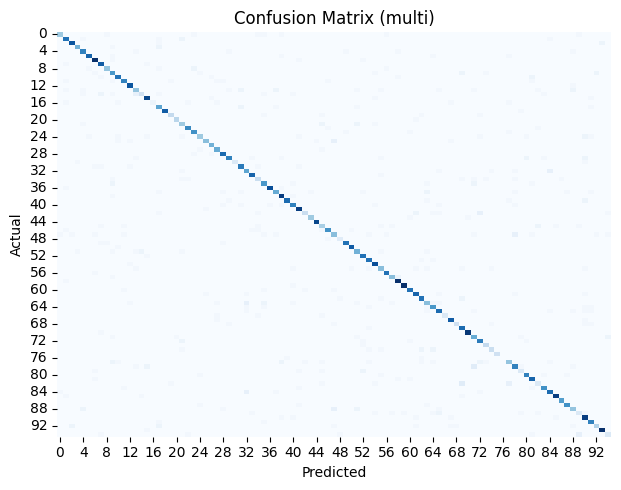


📢 [Evaluation Result] RF - 26 feats (drop IPI_Mean)

✅ Performance Metrics:


,Accuracy,Precision,Recall,F1-Score (Macro)
RF - 26 feats (drop IPI_Mean),0.818984,0.803935,0.784192,0.786485


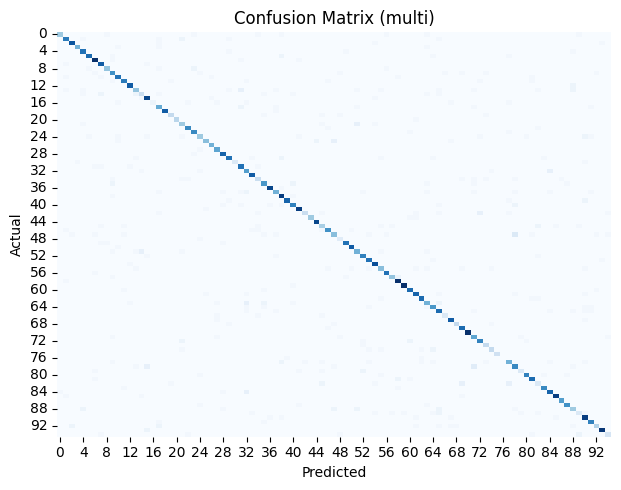

In [14]:
# 37개 전체 feature DataFrame 재확보
X_37 = X_df.copy()
y_all = y_mon

# 공통 IQR 기반 이상치 제거 (37개 전체 기준으로 한 번만 진행함)
def clean_outliers_iqr(df):
    mask = np.ones(len(df), dtype=bool)
    for col in df.columns:
        data = df[col].values
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        col_mask = (data >= lower) & (data <= upper)
        mask &= col_mask
    df_clean = df[mask].reset_index(drop=True)
    return df_clean, mask

# 공통 clean 또한 한 번만 진행하여 변수 통제
X_37_clean, common_mask = clean_outliers_iqr(X_37)
y_clean = y_all[common_mask]

print(f"[Common IQR] 37 feats: {len(X_37)} -> {len(X_37_clean)} samples (공통 데이터)")

# 같은 샘플 subset에서 27 / 26 feature 버전 만들기
zero_importance_feats = [
    'IPI_Min', 'IPI_P10', 'IPI_P25',
    'Size_P90', 'Size_P50', 'Size_P75', 'Size_P10', 'Size_P25',
    'BurstLen_Min', 'BurstVol_Min'
]

# 27개 pruned (zero-importance 10개 제거)
X_27_clean = X_37_clean.drop(columns=zero_importance_feats)

# 26개 (IPI_Mean 추가 제거)
X_26_clean = X_27_clean.drop(columns=["IPI_Mean"])

print("37 feats columns:", X_37_clean.shape[1])
print("27 feats columns:", X_27_clean.shape[1])
print("26 feats columns:", X_26_clean.shape[1])


# 공통 데이터에서만 학습/평가하는 함수
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def train_and_eval_multiclass_noclean(X_df, y, model_name):
    # 1) 공통 clean 데이터에서 split만 수행
    X_train, X_test, y_train, y_test = train_test_split(
        X_df.values, y,
        test_size=0.2,
        stratify=y,
        random_state=42   # 세 모델 공통 seed
    )

    # RF 학습
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # 위에서 정의된 평가함수를 사용해 평가
    evaluate_model_performance(
        rf,
        X_test,
        y_test,
        model_name=model_name,
        scenario="multi"
    )

    return rf

# === 세 가지 모델 공정 비교 (공통 clean + 공통 split) ===
rf_37 = train_and_eval_multiclass_noclean(X_37_clean, y_clean, "RF - 37 feats (baseline)")
rf_27 = train_and_eval_multiclass_noclean(X_27_clean, y_clean, "RF - 27 feats (zero-imp pruned)")
rf_26 = train_and_eval_multiclass_noclean(X_26_clean, y_clean, "RF - 26 feats (drop IPI_Mean)")

In [16]:
X_26_clean.columns

Index(['TotalTime', 'TotalPackets', 'TotalVolume', 'NumIncoming',
       'NumOutgoing', 'IncomingRatio', 'OutgoingRatio', 'InOutDiff',
       'Global_Slope', 'First30_InRatio', 'IPI_Std', 'IPI_Max', 'IPI_Skew',
       'IPI_Kurt', 'IPI_P50', 'IPI_P75', 'IPI_P90', 'BurstLen_Count',
       'BurstLen_Mean', 'BurstLen_Std', 'BurstLen_Max', 'BurstVol_Mean',
       'BurstVol_Std', 'BurstVol_Max', 'CumSum_Mean', 'CumSum_Std'],
      dtype='object')

* 결과 비교: 순서대로 Accuracy, Precision, Recall

RF - 37 feats (baseline): 0.808484,	0.793342,	0.772464

RF - 27 feats (zero-imp pruned):	0.811844,	0.796458,	0.775988

RF - 26 feats (drop IPI_Mean):	0.818984,	0.803935,	0.784192

Feature를 26개 사용하는 모델의 성능이 제일 좋았으므로 최종 선택

+ 추가 실험: 37개에서 27개 Feature로 줄였을 때, 제거한 10개 Feature들의 Ablation Test


=== Baseline: 37 feats (for zero-imp check) ===

📢 [Evaluation Result] RF - 37 feats (baseline for zero-imp)

✅ Performance Metrics:


,Accuracy,Precision,Recall,F1-Score (Macro)
RF - 37 feats (baseline for zero-imp),0.808484,0.793342,0.772464,0.774184


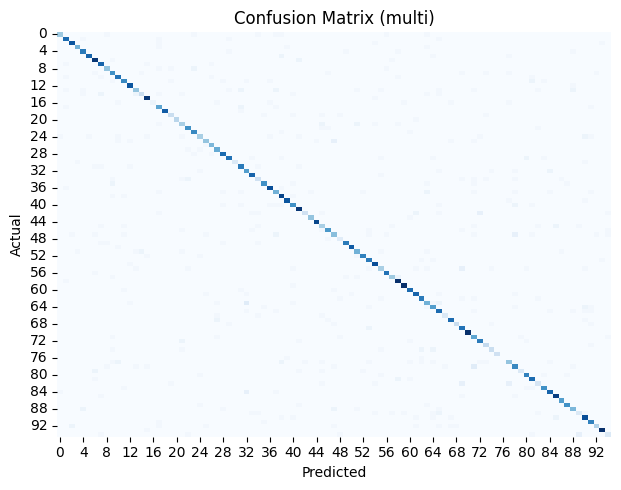


=== Zero-importance features ablation check ===
   removed_feat  acc_after  acc_delta  f1_after  f1_delta
3      Size_P90   0.812684    0.00420  0.779357  0.005173
4      Size_P50   0.812684    0.00420  0.779357  0.005173
5      Size_P75   0.812684    0.00420  0.779357  0.005173
6      Size_P10   0.812684    0.00420  0.779357  0.005173
7      Size_P25   0.812684    0.00420  0.779357  0.005173
9  BurstVol_Min   0.812264    0.00378  0.778594  0.004410
1       IPI_P10   0.809744    0.00126  0.774455  0.000271
2       IPI_P25   0.809744    0.00126  0.774455  0.000271
8  BurstLen_Min   0.809324    0.00084  0.775217  0.001033
0       IPI_Min   0.808484    0.00000  0.773981 -0.000203


In [15]:
# 전제: X_37_clean, y_clean, zero_importance_feats, evaluate_model_performance,
#       train_test_split, RandomForestClassifier 모두 이미 import/정의되어 있다고 가정

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1) 공통 train/test split (37 features 기준)
X_train_37, X_test_37, y_train, y_test = train_test_split(
    X_37_clean.values, y_clean,
    test_size=0.2,
    stratify=y_clean,
    random_state=42
)

# 2) baseline: 37개 그대로
rf_full = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_full.fit(X_train_37, y_train)
print("\n=== Baseline: 37 feats (for zero-imp check) ===")
evaluate_model_performance(rf_full, X_test_37, y_test,
                           model_name="RF - 37 feats (baseline for zero-imp)",
                           scenario="multi")

# 3) zero-importance 애들만 하나씩 제거해보는 ablation
ablation_zero_res = []

for feat in zero_importance_feats:
    cols_keep = [c for c in X_37_clean.columns if c != feat]
    X_sub = X_37_clean[cols_keep]

    # 같은 mask, 같은 split을 쓰기 위해 다시 split
    X_train_sub, X_test_sub, _, _ = train_test_split(
        X_sub.values, y_clean,
        test_size=0.2,
        stratify=y_clean,
        random_state=42
    )

    rf_sub = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf_sub.fit(X_train_sub, y_train)

    # accuracy만 간단히 비교해도 됨 (macro F1도 원하면 추가)
    y_pred_full = rf_full.predict(X_test_37)
    y_pred_sub  = rf_sub.predict(X_test_sub)

    from sklearn.metrics import accuracy_score, f1_score

    acc_full = accuracy_score(y_test, y_pred_full)
    acc_sub  = accuracy_score(y_test, y_pred_sub)
    f1_full  = f1_score(y_test, y_pred_full, average="macro", zero_division=0)
    f1_sub   = f1_score(y_test, y_pred_sub,  average="macro", zero_division=0)

    ablation_zero_res.append({
        "removed_feat": feat,
        "acc_after": acc_sub,
        "acc_delta": acc_sub - acc_full,
        "f1_after": f1_sub,
        "f1_delta": f1_sub - f1_full
    })

# 결과 정리
ablation_zero_df = pd.DataFrame(ablation_zero_res).sort_values(
    ["acc_delta", "f1_delta"], ascending=False
)
print("\n=== Zero-importance features ablation check ===")
print(ablation_zero_df)


* 10개 Feature모두 delta 값이 0.00x이므로, 제거 후 정확도가 상승하지 않았나 분석됨